In [34]:
# Denna modul är för att testa olika modeller och parametrar 
# för att hitta den bästa modellen för att förutsäga kryptovalutor
# Dessutom testar jag att ta med inflation och guldpriser som features
# Nu används yfinance för att hämta data från Yahoo Finance
# Testa också att hämta data från Binance

# 
# TODO: Gör viss preprocessing per kryptovaluta till separate df
# TODO: Gör en merge av utvalda kryptovalutors df
# TODO: Sätt tomorrows up/down (1/0) till en kolumn i df som target
# TODO: Lägg till guldpriser som feature

# HACK: Vi har nu 6 olika Ratio och Trend per TIcker och Datum - FIXA!!
# HACK: Trend måste få en annan definition -  FIXA!! typ Ratio

# TODO: Gör en split av df till train och test
# TODO: Gör en GridSearchCV för en pipeline som innehåller en StandardScaler för olika modeller
# TODO: Skall vi gå vidare med övermorgon också?

# TODO: Gå vidare med logiken i my_crypto.py

In [35]:
import sklearn
import xgboost as xgb
import catboost
from catboost import CatBoostClassifier

# from pytrends.request import TrendReq
# import pytrends
import sys
import numpy as np
import pandas as pd
from datetime import datetime as dt
import yfinance as yf
import ta
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score    
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
# plt.style.use('fivethirtyeight')
import plotly.express as px
import streamlit as st
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV

#Import other useful libraries
import time
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from IPython.display import display
# set display witdh to 200
pd.set_option('display.width', 200)
# set display height to 500
pd.set_option('display.max_rows', 500)
pd.options.display.max_columns = 200    # default 20
pd.options.display.max_colwidth = 60  # default 50
# pd.options.display.precision = 4      # default 6
import logging

# Starta upp logging och inkluder rad nummer
logging.basicConfig(level=logging.INFO, filemode='w', filename='krypto.log', force=True,
                    encoding='utf-8', format= '%(asctime)s - %(levelname)s - %(lineno)d - %(message)s')
logging.info('Startar')


In [36]:
print('Versioner av softvara som används i denna notebook:')
# print numpy version
print('numpy=={}'.format(np.__version__))
# print pandas version
print('pandas=={}'.format(pd.__version__))
# print matplotlib version
print('matplotlib=={}'.format(plt.matplotlib.__version__)) # type: ignore
# print yfinance version
print('yfinance=={}'.format(yf.__version__))
# print pytreands version
print('pytrends==4.8.0') 
# print python-dateutil version
print('python-dateutil==2.8.2')
# print ta version
print('ta==0.10.2')
# print streamlit version
print('streamlit=={}'.format(st.__version__))
print('xgboost=={}'.format(xgb.__version__))
print('catboost=={}'.format(catboost.__version__))

print('sklearn=={}'.format(sklearn.__version__))
#print google version
print('google-crc32==1.1.2')
# print pandas-ta version
print('pandas-ta==0.3.14b0')
# print plotly version
print('plotly==5.3.1')



Versioner av softvara som används i denna notebook:
numpy==1.23.5
pandas==1.4.4
matplotlib==3.7.0
yfinance==0.2.12
pytrends==4.8.0
python-dateutil==2.8.2
ta==0.10.2
streamlit==1.14.0
xgboost==1.7.1
catboost==1.1.1
sklearn==1.0.2
google-crc32==1.1.2
pandas-ta==0.3.14b0
plotly==5.3.1


In [37]:
# TODO Vilka kryptovalutor ska vi använda?
tickers = ['BTC-USD','ETH-USD','BCH-USD','XRP-USD','ZRX-USD']
horizons=[2,5,15,30,60,90,250]

In [38]:
def beräkna_rolling_mean(df, ticker_names, window=20):
    # Funktionen används inte just nu
    rolling_mean=pd.DataFrame()
    for ticker_name in ticker_names:
        df[ticker_name+'-rolling']= df[ticker_name].rolling(window=window).mean()
        
    df.dropna(inplace=True)   
    return df   

def beräkna_cumulative_return(df, ticker_names):
    # Funktionen används inte just nu
    cumulative_return={}
    for ticker_name in ticker_names:
        cumulative_return[ticker_name] = (df[ticker_name].iloc[-1]/df[ticker_name].iloc[0]-1)
    return cumulative_return

## Get inflation data US and SE

In [39]:
def initiate_data(inflation, df_dates, lang_dict, value_name):
    # display(inflation)
    inflation = inflation.melt(
        id_vars=['Year'], var_name='month', value_name=value_name)

    # use lang_dict to translate month names to numbers
    inflation['month'] = inflation['month'].map(lang_dict)

    inflation['Date'] = pd.to_datetime(inflation['Year'].astype(
        str) + '-' + inflation['month'].astype(str))
    inflation.set_index('Date', inplace=True)
    inflation.drop(['Year', 'month'], axis=1, inplace=True)
    inflation = df_dates.merge(
        inflation, how='left', left_on='Date', right_index=True)
    inflation.set_index('Date', inplace=True)
    inflation[value_name] = inflation[value_name].astype(str)
    inflation[value_name] = inflation[value_name].str.replace(',', '.')
    inflation[value_name] = inflation[value_name].str.replace(
        chr(8209), chr(45))
    inflation[value_name] = inflation[value_name].astype(float)
    inflation[value_name].interpolate(method='linear', inplace=True)
    return inflation


def add_horizon_columns(inflation, horizons, SE=True):
    # print(horizons)
    for horizon in horizons:
        # print(horizon)
        inflation['US_inflation_' +
                  str(horizon)] = inflation['US_inflation'].rolling(horizon, 1).mean()
        if SE:
            inflation['SE_inflation_' +
                  str(horizon)] = inflation['SE_inflation'].rolling(horizon, 1).mean()

        # print(inflation.columns)
    return inflation


In [40]:
# US_infl = pd.read_html(
#     'https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
# df_dates = pd.DataFrame(pd.date_range(
#     '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])

# display('Nu SE')
# try:
#     SE_infl = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
# except:
#     display('SE Gick ej bra')
#     SE_infl=pd.DataFrame()
    
# SE_infl

In [41]:
# SE_inflation=SE_infl[0].copy()
# SE_inflation.rename(columns={'År': 'Year'}, inplace=True)
# se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
# SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
# SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
        
# SE_inflation

In [42]:
# US_inflation = US_infl[0].copy()
# US_inflation.replace(to_replace=r'^Avail.*$',
#                      value=np.nan, regex=True, inplace=True)

# US_inflation.columns = US_inflation.iloc[0]
# US_inflation.drop(US_inflation.index[0], inplace=True)
# US_inflation.drop('Ave', axis=1, inplace=True)
# us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    
# US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')
# inflations = pd.concat([US_inflation, SE_inflation], axis=1)
# inflations = inflations.dropna()
# inflations = add_horizon_columns(inflations, [75,90,250])
# inflations

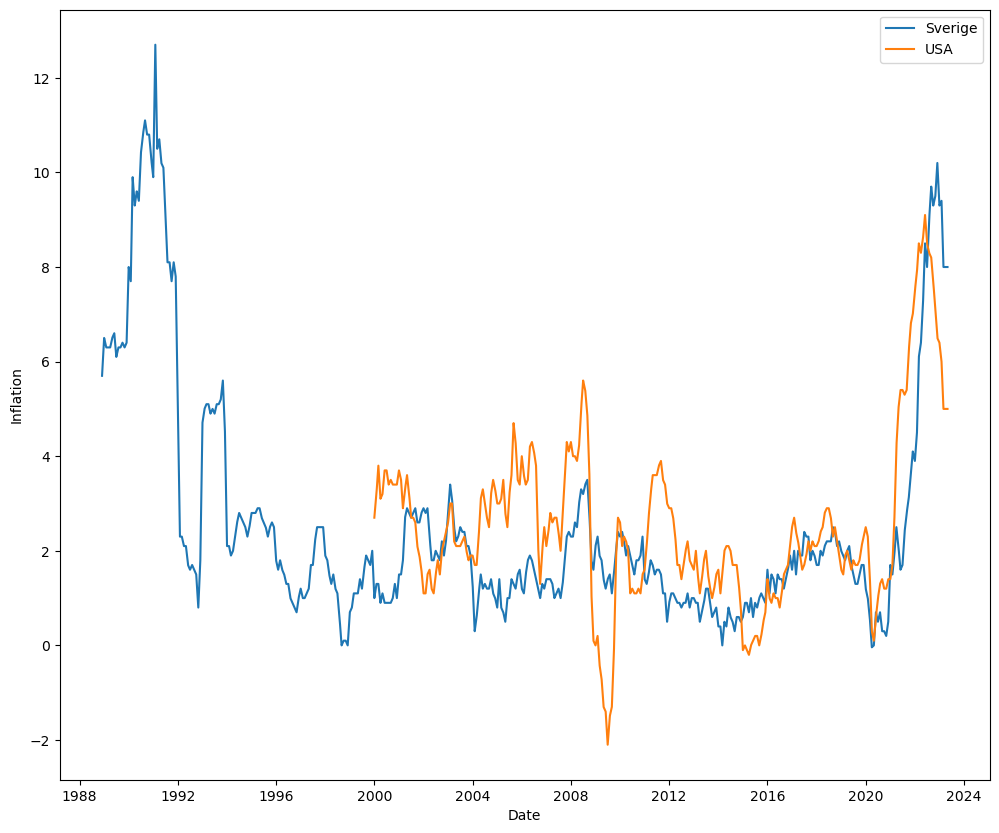

In [43]:

@st.cache_data
def get_inflation_data(graph=False):
    # Explain this function here        
    # Create a dataframe with dates from 1988-12-01 to today
    df_dates = pd.DataFrame(pd.date_range('1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    
    US_inflation = pd.read_html('https://www.usinflationcalculator.com/inflation/current-inflation-rates/')
    US_inflation = US_inflation[0]
    # replace the cell including string starting with "Avail" with the NaN
    US_inflation.replace(to_replace=r'^Avail.*$', value=np.nan, regex=True, inplace=True)
    # set the first row as the header and drop the first row
    US_inflation.columns = US_inflation.iloc[0]
    US_inflation.drop(US_inflation.index[0], inplace=True)
    US_inflation.drop('Ave', axis=1, inplace=True)

    # SE_inflation = pd.DataFrame()
    SE_inflation = pd.read_html('https://www.scb.se/hitta-statistik/statistik-efter-amne/priser-och-konsumtion/konsumentprisindex/konsumentprisindex-kpi/pong/tabell-och-diagram/konsumentprisindex-med-fast-ranta-kpif-och-kpif-xe/kpif-12-manadersforandring/')
    SE_inflation = SE_inflation[0]
    SE_inflation.rename(columns={'År': 'Year'}, inplace=True)

    se_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', Maj='5', Jun='6', Jul='7', Aug='8', Sep='9', Okt='10', Nov='11', Dec='12')
    us_dict = dict(Jan='1', Feb='2', Mar='3', Apr='4', May='5', Jun='6', Jul='7', Aug='8', Sep='9', Oct='10', Nov='11', Dec='12')
    
    SE_inflation = initiate_data(SE_inflation, df_dates, se_dict, value_name='SE_inflation')
    SE_inflation['SE_inflation'] = SE_inflation['SE_inflation'] / 10  # SE_inflation is in percent, divide by 10 to get decimal
    US_inflation = initiate_data(US_inflation, df_dates, us_dict,  value_name='US_inflation')

    if graph:
        # Do a simple plot
        fig, ax = plt.subplots(figsize=(12, 10))
        ax.plot(SE_inflation.index, SE_inflation['SE_inflation'], label='Sverige')
        ax.plot(US_inflation.index, US_inflation['US_inflation'], label='USA')
        ax.set_xlabel('Date')
        ax.set_ylabel('Inflation')
        ax.legend()
        plt.show()

    # concat and set one column to US_index and the other to SE_index
    inflations = pd.concat([US_inflation, SE_inflation], axis=1).copy()
    inflations = inflations.dropna()
    inflations = add_horizon_columns(inflations, [75,90,250])
    return inflations

inflations = get_inflation_data(graph=True)

In [44]:
display(list(inflations.columns))

['US_inflation',
 'SE_inflation',
 'US_inflation_75',
 'SE_inflation_75',
 'US_inflation_90',
 'SE_inflation_90',
 'US_inflation_250',
 'SE_inflation_250']

In [45]:
# fill up a dataframe with all days from 2005 up to today and set it as index
def get_all_dates():
    start_date = dt(2005, 1, 1)
    end_date = dt.today()
    dates = pd.date_range(start_date, end_date)
    df = pd.DataFrame(index=dates)
    return df


## Get Gold data from yfinance

(6739, 1)

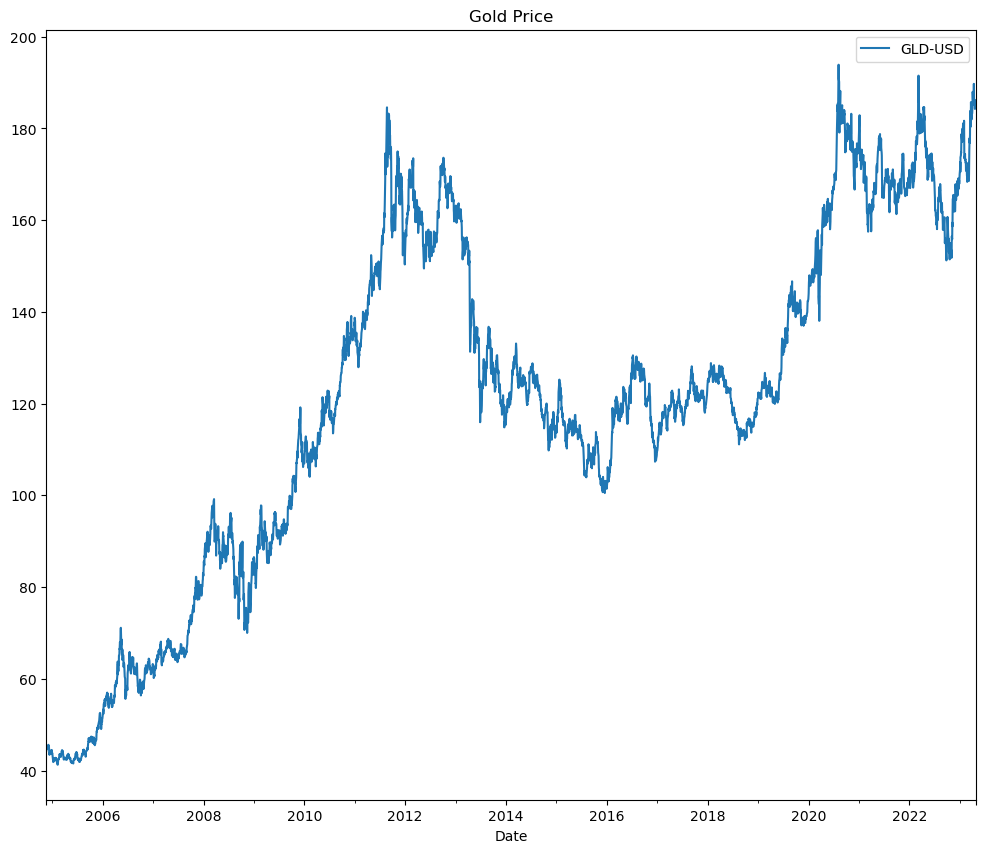

In [46]:
def get_gold_data():
    df_dates = pd.DataFrame(pd.date_range(
        '1988-12-01', pd.to_datetime('today').date()), columns=['Date'])
    df_dates.set_index('Date', inplace=True)
    # Hämta historiska guldprisdata (GLD är ticker-symbolen för SPDR Gold Shares ETF)
    gld_data = yf.download('GLD', end=dt.today().date(), progress=False)
    # gld_data.set_index('Date', inplace=True)
    
    # Behåll endast 'Close' priser och döp om kolumnen till 'GLD-USD'
    gld_data = gld_data[['Close']].rename(columns={'Close': 'GLD-USD'})

    df_dates = pd.DataFrame(pd.date_range(start=gld_data.index[0], end=pd.to_datetime('today').date(), freq='D'), columns=['Date']) # type: ignore

    df_dates.set_index('Date', inplace=True)
    gld_data = df_dates.merge(gld_data, how='left', left_on='Date', right_index=True)
    # interpolating missing values
    gld_data.interpolate(method='linear',inplace=True)
    return gld_data

df_gold = get_gold_data()

display(df_gold.shape)
df_gold.plot(figsize=(12, 10), title='Gold Price')
plt.show()

## Ladda ner all data

In [47]:
def get_all(tickers):
    # Funktionen används inte just nu    
    df = pd.DataFrame()
    for ticker in tickers:
        # all_tickers = yf.download(ticker)
        df[ticker] = yf.download(ticker, period='max')['Close']
        
    df.index = pd.to_datetime(df.index)
    return df

# df_org = get_all(tickers)

In [48]:

def fit_predict(train, test, target, predictors, model, proba_val=None):
    
    if train[target].nunique() < 2:
        print('kolumner i train',train.columns)
        print('kolumner i test',test.columns)
        print('target',target)
        print('predictors',predictors)
        print('train\n',train[target].value_counts())
        print('test\n',test[target].value_counts())
        print(
            f"Skipping training for target {target} as it has only one unique value in the training data.")
        # stäng ner programmet
        sys.exit()
        
    model.fit(train[predictors], train[target])

    if proba_val:  # använd proba
        preds = model.predict_proba(test[predictors])[:, 1]
        preds[preds >= proba_val] = 1
        preds[preds < proba_val] = 0
    else:    # använd predict utan proba
        preds = model.predict(test[predictors])

    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test[target], preds], axis=1)

    return combined


### Beräkna nya kolumner (predictors)

In [49]:
def create_predictors(df_, ticker, target, horizons=[2,5,60,250], ETH_BTC=False):
    df = df_.copy()
    ticker_name = ticker[:3]
    # print(ticker_name)
    # tidsintervall i dagar för rullande medelvärden
    # skulle helst ha med upp till 4 år men ETH har för få värden
    predictors=[]
     
    if ETH_BTC: 
        df['ETH_BTC_ratio'] = df['ETH-USD']/df['BTC-USD']
        predictors += ['ETH_BTC_ratio']
        
        df['ETH_BTC_lag1'] = df['ETH_BTC_ratio'].shift(1)
        predictors += ['ETH_BTC_lag1']
        
        df['ETH_BTC_lag2'] = df['ETH_BTC_ratio'].shift(2)
        predictors += ['ETH_BTC_lag2']
        
        if ticker not in ['BTC-USD', 'ETH-USD']:
            df[ticker_name+'_BTC_ratio'] = df[ticker]/df['BTC-USD']
            predictors += [ticker_name+'_BTC_ratio']
        
            df[ticker_name+'_BTC_lag1'] = df[ticker_name+'_BTC_ratio'].shift(1)
            predictors += [ticker_name+'_BTC_lag1']
            
            df[ticker_name+'_BTC_lag2'] = df[ticker_name+'_BTC_ratio'].shift(2)
            predictors += [ticker_name+'_BTC_lag2']
            
            df[ticker_name+'_ETH_ratio'] = df[ticker]/df['ETH-USD']
            predictors += [ticker_name+'_ETH_ratio']
        
            df[ticker_name+'_ETH_lag1'] = df[ticker_name+'_ETH_ratio'].shift(1)
            predictors += [ticker_name+'_ETH_lag1']
            
            df[ticker_name+'_ETH_lag2'] = df[ticker_name+'_ETH_ratio'].shift(2)
            predictors += [ticker_name+'_ETH_lag2']
    
    # Target
    # display(df)
    # tomorrow's close price - alltså nästa dag
    df['Tomorrow'] = df[ticker].shift(-1)
    # after tomorrow's close price - alltså om två dagar
    df['After_tomorrow'] = df[ticker].shift(-2)
    df['y1'] = (df['Tomorrow'] > df[ticker]).astype(int)
    df['y2'] = (df['After_tomorrow'] > df[ticker]).astype(int)
    # df.dropna(inplace=True)

    hpref = 'GLD_' if 'GLD' in ticker else ''
    for horizon in horizons:
        rolling_averages = df.rolling(horizon, min_periods=1).mean()

        ratio_column = f"{hpref}Ratio_{horizon}"
        df[ratio_column] = df[ticker] / rolling_averages[ticker]
        
        rolling = df.rolling(horizon,closed='left', min_periods=1).mean()
        
        trend_column = f"{hpref}Trend_{horizon}"
        target_name = 'Tomorrow' if target=='y1' else 'After_tomorrow'
        df[trend_column] = rolling[target_name]  

        predictors += [ratio_column, trend_column]

    return df, predictors


# Skapa en GridSearchCV för olika modeller

In [50]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


In [59]:
### get the data ###
df_grid = get_all(tickers)
display('grid:',df_grid.shape)
# inflations = get_inflation_data(graph=False)
display('inflations:',inflations.shape)
df_gold = get_gold_data()
display('gold:',df_gold.shape)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


'grid:'

(3149, 5)

'inflations:'

(8522, 8)

'gold:'

(6739, 1)

### Vi gör viss preprocessing för en valuta i taget - nya kolumner

In [60]:
### preprocessing ###

# TODO: Hur Kan vi få en rad per Date? - Det skall vi inte ha!!
# HACK: Trend måste få en annan definition -  FIXA!! typ Ratio
# HACK: GLD skall integreraras i df_grid


df = pd.DataFrame()
target = 'y1'  # tomorrow
for ticker in tickers:
    # print(ticker)
    df_temp, pred = create_predictors(
        df_grid[[ticker]], ticker, target, horizons=horizons)
    df_temp = df_temp.reset_index()
    df_temp['Ticker'] = ticker
    df = pd.concat([df, df_temp], axis=0)

print('Dessa skall vara lika',sum(df.Date.value_counts()==5)*5,'=',len(df) )
df.Date.value_counts()

Dessa skall vara lika 15745 = 15745


2014-09-17    5
2020-06-09    5
2020-06-11    5
2020-06-12    5
2020-06-13    5
             ..
2017-08-04    5
2017-08-05    5
2017-08-06    5
2017-08-07    5
2023-05-01    5
Name: Date, Length: 3149, dtype: int64

In [ ]:
# target = 'y1'  # tomorrow
# ticker = ['GLD-USD'][0]
# dfg = df_gold.copy()
# ticker_name = ticker[:3]
# display(ticker_name)
# # rename ticker to ticker_name
# # dfg.rename(columns={ticker[0]: ticker_name}, inplace=True)
# predictors = []
# # Target
# # tomorrow's close price - alltså nästa dag
# dfg['Tomorrow'] = dfg[ticker].shift(-1)
# # after tomorrow's close price - alltså om två dagar
# dfg['After_tomorrow'] = dfg[ticker].shift(-2)

# dfg['y1'] = (dfg['Tomorrow'] > dfg[ticker]).astype(int)
# dfg['y2'] = (dfg['After_tomorrow'] > dfg[ticker]).astype(int)
# # df.dropna(inplace=True)
# hpref = 'GLD_'
# for horizon in horizons:
#     display(horizon)
#     rolling_averages = dfg.rolling(horizon, min_periods=1).mean()
#     display(rolling_averages.head(1))
#     ratio_column = f"{hpref}Ratio_{horizon}"
#     dfg[ratio_column] = dfg[ticker] / rolling_averages[ticker]

#     rolling = dfg.rolling(horizon, closed='left', min_periods=1).mean()

#     trend_column = f"{hpref}Trend_{horizon}"
#     target_name = 'Tomorrow' if target == 'y1' else 'After_tomorrow'
#     dfg[trend_column] = rolling[target_name]

#     predictors += [ratio_column, trend_column]


In [61]:
# dfg = pd.DataFrame()

target = 'y1'  # tomorrow
ticker = ['GLD-USD'][0]
# display(df_gold[[ticker]])
dfg, pred = create_predictors(
    df_gold[[ticker]], ticker, target, horizons=horizons)
dfg = dfg.reset_index()

print('Dessa skall vara lika', sum(dfg.Date.value_counts() == 1)*1, '=', len(dfg))
display(dfg.Date.value_counts())
dfg.set_index('Date', inplace=True)
df_gold = dfg[pred].copy()
df_gold

Dessa skall vara lika 6739 = 6739


2004-11-18    1
2017-02-19    1
2017-03-15    1
2017-03-14    1
2017-03-13    1
             ..
2011-01-08    1
2011-01-07    1
2011-01-06    1
2011-01-05    1
2023-05-01    1
Name: Date, Length: 6739, dtype: int64

,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250
Date,,,,,,,,,,,,,,
2004-11-18,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN
2004-11-19,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999,1.004486,44.779999
2004-11-20,1.000632,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332,1.003831,44.808332
2004-11-21,1.000632,44.865000,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666,1.003820,44.836666
2004-11-22,1.000631,44.921667,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000,1.004065,44.865000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-27,1.000027,184.745003,0.999001,184.934667,0.995220,185.637333,0.995944,185.502333,1.019091,181.288999,1.034395,178.606777,1.096184,168.539219
2023-04-28,1.000135,184.775002,0.999081,184.970001,0.997251,185.309333,0.995808,185.578000,1.017889,181.552166,1.034306,178.670481,1.095888,168.630419
2023-04-29,1.000000,184.800003,0.999092,184.968002,0.997811,185.205333,0.995697,185.598667,1.016488,181.802500,1.033928,178.735889,1.095286,168.723059


In [62]:
print('df innan merge')
df=df.set_index('Date')
print(df.shape)
df=df.merge(inflations, left_index=True,
          right_index=True, how='left')

df = df.merge(df_gold, left_index=True, 
           right_index=True, how='left')
print('df efter merge')
print(df.shape)
# df_inflations.shape'
df.sample(20)

df innan merge
(15745, 24)
df efter merge
(15745, 46)


,BTC-USD,Tomorrow,After_tomorrow,y1,y2,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Ticker,ETH-USD,BCH-USD,XRP-USD,ZRX-USD,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-05-20,NaN,0.397603,0.376637,0,0,0.975853,0.407852,0.997832,0.398868,1.122360,0.354613,1.206316,0.329933,1.208497,0.329337,1.224521,0.325028,1.081190,0.368116,XRP-USD,NaN,NaN,0.398003,NaN,1.677419,1.854839,1.877677,1.985355,1.874793,1.957323,1.922737,2.061874,0.999986,120.641666,0.998527,120.818001,0.993592,121.418000,0.996690,121.040667,0.991808,121.636501,0.987046,122.223223,1.008986,119.565600
2019-07-05,10978.459961,11208.550781,11450.846680,1,1,0.989322,11096.948730,0.988338,11107.995898,0.971967,11295.100977,1.109051,9898.967090,1.241515,8842.792489,1.430022,7677.124506,2.020676,5433.061955,BTC-USD,NaN,NaN,NaN,NaN,1.787097,1.474194,1.722237,1.778473,1.754086,1.822616,1.793503,1.932974,0.997189,132.512501,0.997005,132.537001,0.995252,132.770332,1.018790,129.702833,1.050300,125.811667,1.063578,124.241037,1.083815,121.921120
2018-10-25,NaN,203.328995,204.210007,1,1,0.997213,203.285500,0.993630,204.018600,0.999834,202.752732,0.945074,214.500633,0.896581,226.102350,0.762238,265.952312,0.430427,470.971360,ETH-USD,202.718994,NaN,NaN,NaN,2.267742,2.167742,2.402753,2.381527,2.445125,2.357186,2.610301,2.183359,0.998884,116.530003,1.001773,116.194001,1.004233,115.909334,1.017088,114.444334,1.021242,113.978834,1.021456,113.955000,0.970603,119.925460
2017-09-10,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,NaN,NaN,NaN,NaN,2.140000,2.150000,1.945067,2.314000,1.898111,2.297778,2.088923,2.008645,0.997666,127.080002,0.995050,127.414001,1.003986,126.280000,1.019817,124.319667,1.040245,121.878333,1.052071,120.508389,1.066370,118.892400
2018-02-23,NaN,0.920412,0.974205,0,0,1.039880,0.941478,0.975617,1.003493,0.893353,1.095899,0.756757,1.293710,0.713509,1.372125,0.949029,1.031606,1.087457,0.900288,ZRX-USD,NaN,NaN,NaN,0.979024,2.357143,1.935714,2.174762,1.756014,2.162857,1.777341,2.063989,2.004843,0.999366,126.220001,0.999509,126.202000,0.997643,126.438000,0.996039,126.641667,1.000524,126.073917,1.016109,124.140223,1.030672,122.386120
2015-03-24,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BCH-USD,NaN,NaN,NaN,NaN,-0.174194,0.751613,-0.073742,0.840645,-0.068082,0.802545,0.848103,0.613832,1.001223,114.430000,1.004489,114.058000,1.022076,112.095333,1.010671,113.360334,0.983785,116.458417,0.979290,116.992945,0.970193,118.089860
2022-08-12,NaN,0.377964,0.376451,0,0,0.999253,0.380279,1.006088,0.377696,1.010760,0.375950,1.040775,0.365108,1.091769,0.348054,1.040603,0.365168,0.621279,0.611633,XRP-USD,NaN,NaN,0.379995,NaN,8.264516,9.248387,8.564516,8.494860,8.626882,8.425824,8.277103,6.565219,1.004578,167.104996,1.005354,166.975998,1.012860,165.738666,1.030562,162.891665,1.016410,165.159750,1.002379,167.471592,0.974844,172.201920
2014-09-30,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,XRP-USD,NaN,NaN,NaN,NaN,1.700000,0.590000,1.713548,0.442516,1.746774,0.463925,1.795523,0.450000,0.996484,116.619999,0.994285,116.877998,0.991294,117.230666,0.977605,118.872083,0.954869,121.702583,0.943277,123.198166,0.933761,124.453700
2016-03-22,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ETH-USD,NaN,NaN,NaN,NaN,1.035484,1.432258,1.023484,1.346581,1.074194,1.376022,0.624761,1.132168,1.001469,119.134998,0.999531,119.366000,0.998839,119.448667,1.002041,119.067000,1.032206,115.587417,1.068890,111.620445,1.100953,108.369760


In [63]:
df.dropna(subset=['Tomorrow'], inplace=True)
df.dropna(subset=[target], inplace=True)
df2 = df.drop(columns=['After_tomorrow', 'ETH-USD','BTC-USD',	'BCH-USD',	'XRP-USD',	'ZRX-USD'])
df2.shape

# df2['GLD-USD'] = df2['GLD-USD'].interpolate()
# print df2 for Januay 2022
# df2.isna().sum()
df2

,Tomorrow,y1,y2,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,Ticker,US_inflation,SE_inflation,US_inflation_75,SE_inflation_75,US_inflation_90,SE_inflation_90,US_inflation_250,SE_inflation_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2014-09-17,424.440002,0,0,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,1.000000,NaN,BTC-USD,1.7,0.46,1.748774,0.449058,1.792444,0.478889,1.776903,0.443240,0.994542,118.185001,0.992686,118.406000,0.979380,120.014667,0.966531,121.610167,0.951879,123.482083,0.943007,124.643833,0.943171,124.622120
2014-09-18,394.795990,0,0,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,0.962696,424.440002,BTC-USD,1.7,0.47,1.745290,0.447497,1.788704,0.476630,1.777948,0.443520,1.001020,117.660000,0.995868,118.268667,0.983768,119.723334,0.970340,121.380167,0.954917,123.340583,0.945668,124.546944,0.945180,124.611186
2014-09-19,408.903992,1,1,0.963815,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,0.927789,409.617996,BTC-USD,1.7,0.48,1.741935,0.446112,1.785000,0.474556,1.779058,0.443840,0.997062,117.434998,0.992490,117.975999,0.980401,119.430667,0.966548,121.142500,0.950511,123.186417,0.940927,124.441092,0.939754,124.596480
2014-09-20,398.821014,0,0,1.017554,401.849991,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,0.970419,409.379995,BTC-USD,1.7,0.49,1.738710,0.444903,1.781333,0.472667,1.780232,0.444200,0.999658,117.049997,0.994560,117.649999,0.982501,119.094000,0.967450,120.946834,0.950984,123.040917,0.941101,124.333055,0.939232,124.580440
2014-09-21,402.152008,1,1,0.987517,403.862503,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,0.956729,406.740250,BTC-USD,1.7,0.50,1.735613,0.443871,1.777704,0.470963,1.781471,0.444600,0.999658,116.969997,0.997101,117.269998,0.984412,118.781555,0.968459,120.738167,0.951454,122.896083,0.941292,124.222833,0.938680,124.568600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,28262.919922,0,0,1.000347,29258.647461,1.004048,29150.808984,1.017457,28766.626563,1.014250,28857.574544,1.083559,27011.743555,1.135419,25777.972721,1.369113,21377.926164,BTC-USD,5.0,8.00,5.050000,8.070000,5.172366,8.241075,6.361465,9.092948,1.000000,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.036500,1.033540,178.803000,1.094714,168.811179
2023-04-30,1837.783936,0,0,0.991549,1892.920654,0.992692,1890.740942,0.973179,1928.652905,0.979128,1916.934652,1.044857,1796.344987,1.079246,1739.106955,1.244534,1508.134000,ETH-USD,5.0,8.00,5.050000,8.070000,5.172366,8.241075,6.361465,9.092948,1.000000,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.036500,1.033540,178.803000,1.094714,168.811179
2023-04-30,116.757965,0,0,0.993582,118.980194,1.000252,118.186848,0.963588,122.683690,0.944788,125.124943,0.946353,124.917996,0.924941,127.809790,0.997818,118.475029,BCH-USD,5.0,8.00,5.050000,8.070000,5.172366,8.241075,6.361465,9.092948,1.000000,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.036500,1.033540,178.803000,1.094714,168.811179


In [64]:
# print df för a specific Data
df2.sort_index(ascending=True, inplace=True)
df2.dropna(inplace=True)

In [65]:
df2.columns

Index(['Tomorrow', 'y1', 'y2', 'Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250',
       'Ticker', 'US_inflation', 'SE_inflation', 'US_inflation_75', 'SE_inflation_75', 'US_inflation_90', 'SE_inflation_90', 'US_inflation_250', 'SE_inflation_250', 'GLD_Ratio_2', 'GLD_Trend_2',
       'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15', 'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250'],
      dtype='object')

In [66]:
predictors = ['Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90',
              'Ratio_250', 'Trend_250', 'GLD_Ratio_2', 'GLD_Trend_2', 'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15',
              'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250', 'US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250']


In [67]:
df2[predictors].tail(10)

,Ratio_2,Trend_2,Ratio_5,Trend_5,Ratio_15,Trend_15,Ratio_30,Trend_30,Ratio_60,Trend_60,Ratio_90,Trend_90,Ratio_250,Trend_250,GLD_Ratio_2,GLD_Trend_2,GLD_Ratio_5,GLD_Trend_5,GLD_Ratio_15,GLD_Trend_15,GLD_Ratio_30,GLD_Trend_30,GLD_Ratio_60,GLD_Trend_60,GLD_Ratio_90,GLD_Trend_90,GLD_Ratio_250,GLD_Trend_250,US_inflation,US_inflation_75,US_inflation_90,US_inflation_250
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2023-04-29,0.998434,29294.375000,1.010012,28958.567188,1.014283,28836.605859,1.014472,28831.230469,1.086576,26918.039290,1.137784,25706.543077,1.370147,21346.963289,1.0,184.800003,0.999092,184.968002,0.997811,185.205333,0.995697,185.598667,1.016488,181.8025,1.033928,178.735889,1.095286,168.723059,5.0,5.057143,5.183763,6.374381
2023-04-29,1.004315,1900.714905,1.010701,1888.706812,0.982447,1943.022404,0.996769,1915.104578,1.064776,1792.786810,1.099818,1735.666980,1.266467,1507.277382,1.0,184.800003,0.999092,184.968002,0.997811,185.205333,0.995697,185.598667,1.016488,181.8025,1.033928,178.735889,1.095286,168.723059,5.0,5.057143,5.183763,6.374381
2023-04-29,1.006793,118.935883,1.009786,118.583354,0.968360,123.656304,0.955520,125.318017,0.956534,125.185051,0.935858,127.950783,1.010188,118.536143,1.0,184.800003,0.999092,184.968002,0.997811,185.205333,0.995697,185.598667,1.016488,181.8025,1.033928,178.735889,1.095286,168.723059,5.0,5.057143,5.183763,6.374381
2023-04-29,0.998058,0.479340,1.014619,0.471516,0.988774,0.483841,0.960385,0.498143,1.056501,0.452824,1.106331,0.432428,1.161283,0.411966,1.0,184.800003,0.999092,184.968002,0.997811,185.205333,0.995697,185.598667,1.016488,181.8025,1.033928,178.735889,1.095286,168.723059,5.0,5.057143,5.183763,6.374381
2023-04-29,0.999459,0.262519,0.999962,0.262387,0.960897,0.273054,0.922968,0.284275,1.016526,0.258112,1.028037,0.255221,1.104561,0.237540,1.0,184.800003,0.999092,184.968002,0.997811,185.205333,0.995697,185.598667,1.016488,181.8025,1.033928,178.735889,1.095286,168.723059,5.0,5.057143,5.183763,6.374381
2023-04-30,1.000347,29258.647461,1.004048,29150.808984,1.017457,28766.626563,1.014250,28857.574544,1.083559,27011.743555,1.135419,25777.972721,1.369113,21377.926164,1.0,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.0365,1.033540,178.803000,1.094714,168.811179,5.0,5.050000,5.172366,6.361465
2023-04-30,0.991549,1892.920654,0.992692,1890.740942,0.973179,1928.652905,0.979128,1916.934652,1.044857,1796.344987,1.079246,1739.106955,1.244534,1508.134000,1.0,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.0365,1.033540,178.803000,1.094714,168.811179,5.0,5.050000,5.172366,6.361465
2023-04-30,0.993582,118.980194,1.000252,118.186848,0.963588,122.683690,0.944788,125.124943,0.946353,124.917996,0.924941,127.809790,0.997818,118.475029,1.0,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.0365,1.033540,178.803000,1.094714,168.811179,5.0,5.050000,5.172366,6.361465
2023-04-30,0.993608,0.475370,1.000739,0.471983,0.982729,0.480633,0.952402,0.495938,1.039696,0.454298,1.090101,0.433292,1.145139,0.412467,1.0,184.800003,1.000119,184.778003,0.998273,185.119778,0.995414,185.651334,1.015181,182.0365,1.033540,178.803000,1.094714,168.811179,5.0,5.050000,5.172366,6.361465


### Preprocessing för alla valutor tillsammans

In [68]:

tscv = TimeSeriesSplit(n_splits=5)

In [69]:
l = predictors+['y1']
print(l)
X = df2[l].dropna()
y = X['y1']
X = X.drop(['y1'], axis=1)
print(y.shape)
X.shape

['Ratio_2', 'Trend_2', 'Ratio_5', 'Trend_5', 'Ratio_15', 'Trend_15', 'Ratio_30', 'Trend_30', 'Ratio_60', 'Trend_60', 'Ratio_90', 'Trend_90', 'Ratio_250', 'Trend_250', 'GLD_Ratio_2', 'GLD_Trend_2', 'GLD_Ratio_5', 'GLD_Trend_5', 'GLD_Ratio_15', 'GLD_Trend_15', 'GLD_Ratio_30', 'GLD_Trend_30', 'GLD_Ratio_60', 'GLD_Trend_60', 'GLD_Ratio_90', 'GLD_Trend_90', 'GLD_Ratio_250', 'GLD_Trend_250', 'US_inflation', 'US_inflation_75', 'US_inflation_90', 'US_inflation_250', 'y1']
(11143,)


(11143, 32)

In [70]:
# Initialize the hyperparameters for each dictionary
# each having a key as ‘classifier’ and value as estimator object.
#The hyperparameter keys should start with the word classifier separated
# by ‘__’ (double underscore)

# Define parameters for CatBoostClassifier
paramCat = {}
paramCat['classifier__iterations'] = [100, 250, 300]
paramCat['classifier__depth'] = [3, 5, 7]
paramCat['classifier__class_weights'] = [{0: 1, 1: 1}, {0: 1, 1: 2} ]
paramCat['classifier__learning_rate'] = [0.01, 0.03, 0.05]
paramCat['classifier'] = [CatBoostClassifier(random_state=42, verbose=False)]
#Total parameters to test (3 * 3 * 2 * 3) = 54

# Define parameters for XGBClassifier
paramXGB = {}
paramXGB['classifier__n_estimators'] = [50, 100, 250]
paramXGB['classifier__max_depth'] = [2, 3, 5, 10]
paramXGB['classifier__scale_pos_weight'] = [1, 5, 10]
paramXGB['classifier'] = [XGBClassifier(
    random_state=42, eval_metric='logloss')]
#Total parameters to test (3 * 3 * 3) = 27

# Define parameters for Random Forest
paramRF = {}
paramRF['classifier__n_estimators'] = [75, 100, 200, 350]
paramRF['classifier__max_depth'] = [ 5, 10, 12]
paramRF['classifier__class_weight'] = [None, {0: 1, 1: 5}]
paramRF['classifier'] = [RandomForestClassifier(random_state=42)]
#Total parameters to test (4 * 3 * 2) = 24

# Define parameters for support vector machine (SVC)
paramSVC = {}
paramSVC['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
paramSVC['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 25}]
paramSVC['classifier'] = [SVC(random_state=42)]
#Total parameters to test (5 * 4) = 20

# Define parameters for Logistic regression
paramLR = {}
paramLR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1]
paramLR['classifier__penalty'] = ['l1', 'l2']
paramLR['classifier__solver'] = ['liblinear', 'saga']  # or 'saga'
paramLR['classifier__class_weight'] = [
    None, {0: 1, 1: 5}, {0: 1, 1: 10}]
paramLR['classifier'] = [LogisticRegression(random_state=42)]
#Total parameters to test (4 * 2 * 2 * 3) = 48

# Define parameters for K neighbors
paramKN = {}
paramKN['classifier__n_neighbors'] = [2, 5, 10, 25, 50]
paramKN['classifier'] = [KNeighborsClassifier()]
#Total 5 parameters to test (5)

# Define parameters for Gradient boosting
paramGBC = {}
paramGBC['classifier__n_estimators'] = [10, 50, 100]
paramGBC['classifier__max_depth'] = [3, 5, 10]
paramGBC['classifier'] = [GradientBoostingClassifier(random_state=42)]
#Total parameters to test (3 * 3) = 9

# define the pipeline to include scaling and the model.
# Prepare the pipeline for the 1st model, others will be loaded appropriately
#during the Grid Search
#This pipeline will be the input to cross_val_score, instead of the model.
steps = list()
steps.append(('scaler', StandardScaler()))
steps.append(('classifier', RandomForestClassifier(random_state=42)))
pipeline = Pipeline(steps=steps)

#Capture all parameter dictionaries as a list
params = [paramRF, paramSVC, paramLR, paramKN, paramGBC]
# Total parameters for all 5 models = 27+20+48+5+9 = 109

### GridSearchCV för lätta modeller

In [71]:
# take the time
start_time = time.time()
#Grid search - including cross validation
grid = GridSearchCV(pipeline, params, cv=tscv, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

#Gridsearch object (in our case 'grid') stores all the information about
#the best model and corresponding hyperparameters.
# print the best parameters...
print(grid.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid.best_score_)

# Stats for each test - we have a total 125 tests
means = grid.cv_results_['mean_test_score']
params_summary = grid.cv_results_['params']
# print the time taken
print("--- %s seconds ---" % round((time.time() - start_time),1))

{'classifier': LogisticRegression(C=0.01, class_weight={0: 1, 1: 5}, penalty='l1',
                   random_state=42, solver='saga'), 'classifier__C': 0.01, 'classifier__class_weight': {0: 1, 1: 5}, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
0.5297813770515
--- 221.1 seconds ---


In [72]:

#Capture all data into a Data Frame
df_res1 = pd.DataFrame(list(zip(means, params_summary)),
                  columns=['Mean Score', 'Parmeters']).sort_values(by=['Mean Score'], ascending=False)


In [73]:
df_res1 = df_res1.sort_values(by='Mean Score', ascending=False)
df_res1.to_csv('GridSearchResults1.csv', index=False)

In [74]:
df_res1 = pd.read_csv('GridSearchResults1.csv')

df_res1.head()

,Mean Score,Parmeters
0,0.529781,"{'classifier': LogisticRegression(C=0.01, class_weight={..."
1,0.529744,"{'classifier': LogisticRegression(C=0.01, class_weight={..."
2,0.528960,"{'classifier': LogisticRegression(C=0.01, class_weight={..."
3,0.526075,"{'classifier': LogisticRegression(C=0.01, class_weight={..."
4,0.525642,"{'classifier': LogisticRegression(C=0.01, class_weight={..."


### RandomizedSearchCV av de två tunga modellerna

In [75]:
from sklearn.model_selection import RandomizedSearchCV

# Add the new parameter dictionaries to the list
params = [paramCat, paramXGB]
# Total parameters for all 2 models = 144+48 = 192

# Make RandomizedSearch one by one for each model - because it takes so long time

# Number of iterations for randomized search
n_iter_search = 30

#### Random search XGB - including cross validation ####
# Take the time
start_time = time.time()
random2a = RandomizedSearchCV(
    pipeline, param_distributions=params[1:], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

# print the best parameters...
print(random2a.best_params_)

# print best score for the best model (in our case roc_auc score)
print(random2a.best_score_)

# Stats for each test - we have a total 48 tests
means2a = random2a.cv_results_['mean_test_score']
params_summary2a = random2a.cv_results_['params']

#Capture all data into a Data Frame
df_res2a = pd.DataFrame(list(zip(means2a, params_summary2a)),
                        columns=['Mean Score', 'Parmeters'])

# Take the time
print("--- The XGB time was %s seconds ---" % round((time.time() - start_time), 1))
df_res2a = df_res2a.sort_values(by='Mean Score', ascending=False)
df_res2a.to_csv('RandomSearchResults2a.csv', index=False)

display(df_res2a.head())

#### Random search CATB - including cross validation ####
# Take the time
start_time = time.time()
random2b = RandomizedSearchCV(
    pipeline, param_distributions=params[:1], n_iter=n_iter_search, cv=tscv, n_jobs=-1, scoring='roc_auc', random_state=42).fit(X, y)

# print the best parameters...
print(random2b.best_params_)

# print best score for the best model (in our case roc_auc score)
print(random2b.best_score_)

# Stats for each test - we have a total 144 tests
means2b = random2b.cv_results_['mean_test_score']
params_summary2b = random2b.cv_results_['params']

#Capture all data into a Data Frame
df_res2b = pd.DataFrame(list(zip(means2b, params_summary2b)),
                        columns=['Mean Score', 'Parmeters'])
df_res2b =df_res2b.sort_values(by='Mean Score', ascending=False)  
df_res2b.to_csv('RandomSearchResults2b.csv', index=False)

display(df_res2b.head())
# Take the time
print("--- The Cat time was %s seconds ---" % round((time.time() - start_time), 1))


{'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 250, 'classifier__max_depth': 3, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=250, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)}
0.5350441276258112
--- The XGB time was 73.0 seconds ---


,Mean Score,Parmeters
15,0.535044,"{'classifier__scale_pos_weight': 1, 'classifier__n_estim..."
7,0.529429,"{'classifier__scale_pos_weight': 1, 'classifier__n_estim..."
2,0.525452,"{'classifier__scale_pos_weight': 10, 'classifier__n_esti..."
0,0.524875,"{'classifier__scale_pos_weight': 10, 'classifier__n_esti..."
6,0.524327,"{'classifier__scale_pos_weight': 1, 'classifier__n_estim..."


{'classifier__learning_rate': 0.03, 'classifier__iterations': 250, 'classifier__depth': 3, 'classifier__class_weights': {0: 1, 1: 1}, 'classifier': <catboost.core.CatBoostClassifier object at 0x000001F6740DF2E0>}
0.5401700077308119


,Mean Score,Parmeters
15,0.540170,"{'classifier__learning_rate': 0.03, 'classifier__iterati..."
4,0.537637,"{'classifier__learning_rate': 0.05, 'classifier__iterati..."
21,0.533717,"{'classifier__learning_rate': 0.01, 'classifier__iterati..."
14,0.533480,"{'classifier__learning_rate': 0.03, 'classifier__iterati..."
16,0.533417,"{'classifier__learning_rate': 0.03, 'classifier__iterati..."


--- The Cat time was 102.6 seconds ---


### GridSearchCV

In [ ]:
# Add the new parameter dictionaries to the list
params = [paramCat, paramXGB]
# Total parameters for all 2 models = 144+48 = 192


In [ ]:
# Make GridSearch one by one for each model - because it takes so long time

#### Grid search XGB - including cross validation ####
# Take the time
start_time = time.time()
grid2a = GridSearchCV(pipeline, params[1:], cv=tscv, n_jobs=-
                    1, scoring='roc_auc').fit(X, y)

# print the best parameters...
print(grid2a.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid2a.best_score_)

# Stats for each test - we have a total 48 tests
means2a = grid2a.cv_results_['mean_test_score']
params_summary2a = grid2a.cv_results_['params']

#Capture all data into a Data Frame
df_res2a = pd.DataFrame(list(zip(means2a, params_summary2a)),
                  columns=['Mean Score', 'Parmeters'])

df_res2a.to_csv('GridSearchResults2a.csv', index=False)

# Take the time
print("--- The time was %s seconds ---" % round((time.time() - start_time),1))

In [ ]:
df_res2a = pd.read_csv('GridSearchResults2a.csv').sort_values(
    by='Mean Score', ascending=False)

df_res2a.head()

In [ ]:
#### Grid search CATB - including cross validation ####
# Take the time
start_time = time.time()
grid2b = GridSearchCV(pipeline, params[:1], cv=tscv, n_jobs=-
                      1, scoring='roc_auc').fit(X, y)
# print the best parameters...
print(grid2b.best_params_)

# print best score for the best model (in our case roc_auc score)
print(grid2b.best_score_)

# Stats for each test - we have a total 144 tests
means2b = grid2b.cv_results_['mean_test_score']
params_summary2b = grid2b.cv_results_['params']

#Capture all data into a Data Frame
df_res2b = pd.DataFrame(list(zip(means2b, params_summary2b)),
                        columns=['Mean Score', 'Parmeters'])

df_res2b.to_csv('GridSearchResults2b.csv', index=False)

# Take the time
print("--- The time was %s seconds ---" % round((time.time() - start_time),1))

In [102]:

import re
import ast

df_res1 = pd.read_csv('GridSearchResults1.csv')
df_res2a = pd.read_csv('RandomSearchResults2a.csv')
df_res2a['Model'] = 'XGBoost_Classifier'
df_res2b = pd.read_csv('RandomSearchResults2b.csv')
df_res2b['Model'] = 'CatBoostClassifier'
df_res = pd.concat([df_res1, df_res2a, df_res2b], ignore_index=True).sort_values(
    by='Mean Score', ascending=False)
df_res.to_csv('GridSearchResults.csv', index=False)


def extract_model_and_params(row):
    model_regex = r'\'classifier\':\s*([^,]+)'
    param_regex = r'\'classifier__([a-zA-Z0-9_]+)\':\s*([^,}]+)'

    model_match = re.search(model_regex, row['Parmeters'])
    model = model_match.group(1) if model_match else 'Unknown'

    # Ersätt objektreferenser med klassnamn
    model = re.sub(r'<[^>]*>', lambda x: 'CatBoostClassifier' if 'catboost' in x.group(0)
                   else x.group(0).split('.')[1], model)

    # Ta bort allt efter och inklusive '('
    model = re.sub(r'\(.*', '', model).strip()

    params = re.findall(param_regex, row['Parmeters'])
    params_clean = {k: v.strip() for k, v in params}

    return pd.Series([model, params_clean])


# Skapa nya kolumner för model och parametrar utan 'classifier__' prefix
df_res[['Model', 'Parameters_clean']] = df_res.apply(extract_model_and_params, axis=1)
df_res.sort_values(by='Mean Score', ascending=False, inplace=True)
# Ta bort den gamla 'Parameters' kolumnen
df_res = df_res.drop(columns=['Parmeters'])


print(
    f'The winner is {df_res.iloc[0]["Model"]} with params\n {df_res.iloc[0]["Parameters_clean"]}')

# Visa den resulterande DataFrame
print()
print(df_res.query("Model == 'CatBoostClassifier}'").values[:1])
print(df_res.query("Model == 'XGBClassifier'").values[:1])
print(df_res.query("Model == 'RandomForestClassifier'").values[:1])
print(df_res.query("Model == 'GradientBoostingClassifier'").values[:1])

print(df_res.query("Model == 'LogisticRegression'").values[:1])
print(df_res.query("Model == 'KNeighborsClassifier'").values[:1])
print(df_res.query("Model == 'SVC'").values[:1])


The winner is CatBoostClassifier} with params
 {'learning_rate': '0.03', 'iterations': '250', 'depth': '3', 'class_weights': '{0: 1'}

[[0.5401700077308119 'CatBoostClassifier}'
  {'learning_rate': '0.03', 'iterations': '250', 'depth': '3', 'class_weights': '{0: 1'}]]
[[0.5350441276258112 'XGBClassifier'
  {'scale_pos_weight': '1', 'n_estimators': '250', 'max_depth': '3'}]]
[[0.520890119217537 'RandomForestClassifier'
  {'class_weight': 'None', 'max_depth': '10', 'n_estimators': '300'}]]
[[0.5236698726421649 'GradientBoostingClassifier'
  {'max_depth': '5', 'n_estimators': '50'}]]
[[0.5297813770515 'LogisticRegression'
  {'C': '0.01', 'class_weight': '{0: 1', 'penalty': "'l1'", 'solver': "'saga'"}]]
[[0.5116073503622939 'KNeighborsClassifier' {'n_neighbors': '5'}]]
[[0.5119583606048228 'SVC' {'C': '10', 'class_weight': '{0: 1'}]]


In [103]:
df_res.Model.nunique()

7

TODO: Lista följer - 
1. Välj ut en modell CatBoost    
   'learning_rate': '0.03', 'iterations': '250', 'depth': '3'
2. Lägg till varians 

3. Ta fram en StandardScaler per currency i Binance - spara enligt namnstandard XXX_scaler.pkl
4. Överför till .py som skall ha en pipeline enligt ChatGpt

# Tester